# Identification
Please indicate your name

Student 1: 

Student 2: 

# Practical work 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [1]:
# Load useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal

# Useful functions 
def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern = np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return  kern/kern.sum()

## Exercise 1: Harris response calculation

1) Write a function `computeR(I, scale, kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussianKernel()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [2]:
def computeR(image,scale,kappa):
    """ Array[n, m]*float*float->Array[n, m]
    """
    sigma = (scale-1)/6
    sobel_x = np.array([[1, 0, -1],
                        [2, 0, -2],
                        [1, 0, -1]])
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]])

    I_x = scipy.signal.convolve2d(image, sobel_x, mode='same')
    I_y = scipy.signal.convolve2d(image, sobel_y, mode='same')
    I_x_2 = I_x * I_x
    I_y_2 = I_y* I_y
    I_x_I_y = I_x * I_y
    
    gaussian = gaussianKernel(sigma)
    A = scipy.signal.convolve2d(I_x_2, gaussian, mode='same')
    B = scipy.signal.convolve2d(I_x_I_y, gaussian, mode='same')
    D = scipy.signal.convolve2d(I_y_2, gaussian, mode='same')
    
    det = A * D - B * B
    trace = A + D
    return det - kappa * (trace ** 2)
    

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

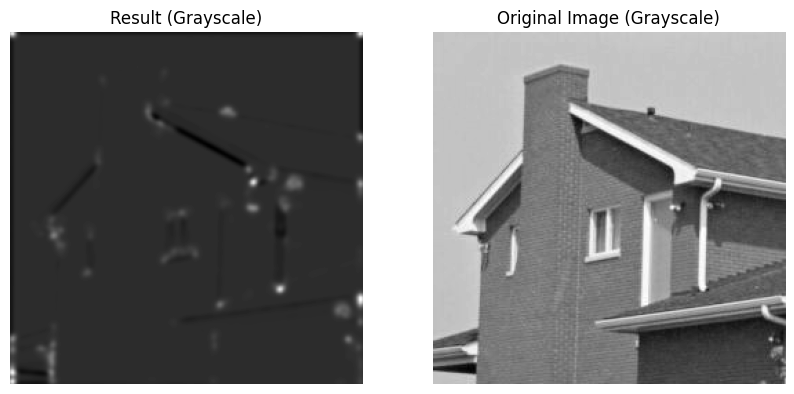

In [3]:
house2 = np.array(Image.open('img/house2.png').convert('L'))

res = computeR(house2, 15, 0.04)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(res, cmap='gray')
axs[0].set_title('Result (Grayscale)')

axs[1].imshow(house2, cmap='gray')
axs[1].set_title('Original Image (Grayscale)')

for ax in axs:
    ax.axis('off')
plt.show()

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

Your answer...

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [4]:
def thresholdR(R, thres):
    """ Array[n, m] * float -> Array[n, m]
    """
    R_b = np.zeros(R.shape)
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            if R[i][j] < thres:
                R_b[i][j] = 0
            else:
                R_b[i][j] = 1
    return R_b

2) A function `Rnms(R, Rbin)` that performs a non-maximum supression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater value $R$ than its 8 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

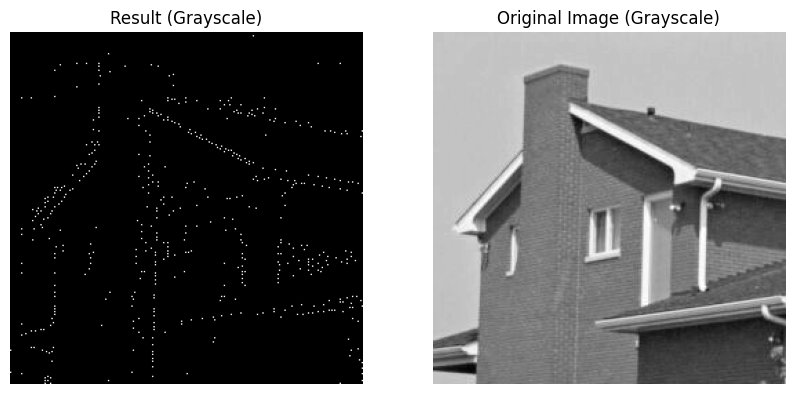

In [5]:
def Rnms(R, Rbin):
    """ Array[n, m] -> Array[n, m] 
    """
    R_locmax = np.zeros(R.shape)
    
    for i in range(R_locmax.shape[0]):
        for j in range(R_locmax.shape[1]):
            neighbors = []
            if i > 0 and j > 0:  # Top-left
                neighbors.append(R[i-1, j-1])
            if i > 0:  # Top-center
                neighbors.append(R[i-1, j])
            if i > 0 and j < R.shape[1] - 1:  # Top-right
                neighbors.append(R[i-1, j+1])
            if j > 0:  # Middle-left
                neighbors.append(R[i, j-1])
            if j < R.shape[1] - 1:  # Middle-right
                neighbors.append(R[i, j+1])
            if i < R.shape[0] - 1 and j > 0:  # Bottom-left
                neighbors.append(R[i+1, j-1])
            if i < R.shape[0] - 1:  # Bottom-center
                neighbors.append(R[i+1, j])
            if i < R.shape[0] - 1 and j < R.shape[1] - 1:  # Bottom-right
                neighbors.append(R[i+1, j+1])
            
            maximum = max(neighbors) if neighbors else float('-inf')
            if Rbin[i][j] == 1 and R[i][j] > maximum:
                R_locmax[i][j] = 1
    return R_locmax
    
res = Rnms(house2,thresholdR(house2, 141))
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(res, cmap='gray')
axs[0].set_title('Result (Grayscale)')

axs[1].imshow(house2, cmap='gray')
axs[1].set_title('Original Image (Grayscale)')

for ax in axs:
    ax.axis('off')
plt.show()

3) Write a function ``cornerDetector(image, scale, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

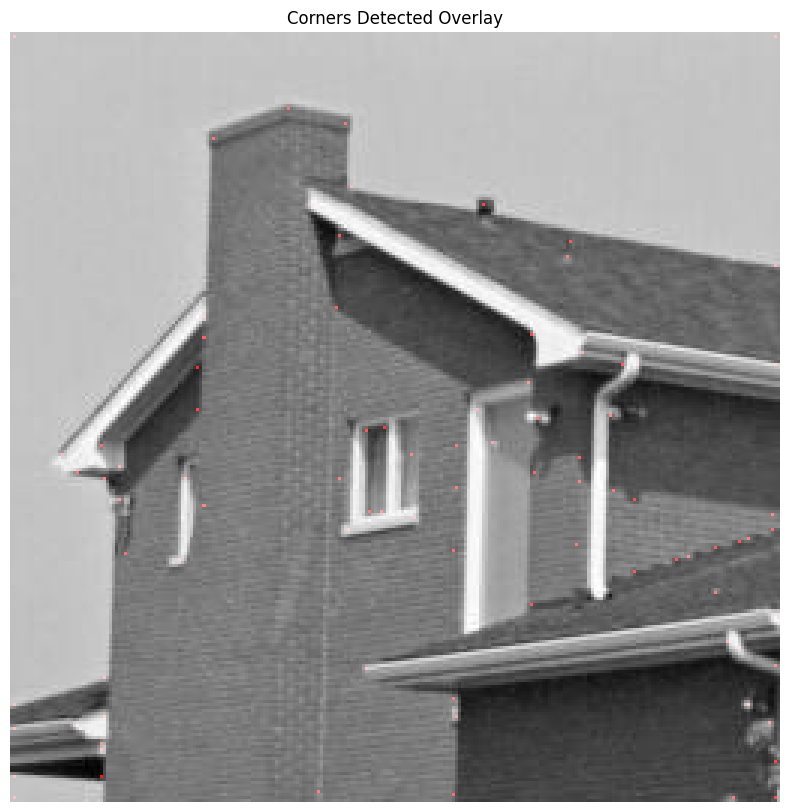

In [6]:
def cornerDetector(image, scale, kappa, thres):
    """ Array[n, m]*float*float*float -> Array[n, m]
    """
    R = computeR(image, scale, kappa)
    R_bin = (R > thres).astype(np.float32)  # 1 where R > thresh, else 0
    corners = Rnms(R, R_bin)
    return corners



thres = 4300000
corners_detected = cornerDetector(house2, scale=15, kappa=0.04, thres=thres)

# Create a color mask
color_mask = np.zeros((*corners_detected.shape, 3), dtype=np.uint8)  # RGB mask
color_mask[corners_detected == 1] = [255, 0, 0]  # Red color for corners

# Convert the original grayscale image to RGB
original_rgb = np.stack((house2,) * 3, axis=-1)

# Overlay the mask on the original image
overlay_image = np.where(color_mask == 0, original_rgb, color_mask)

# Display the overlay result
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Corners Detected Overlay")
plt.axis('off')  # Hide axes
plt.show()


4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

## Exercise 3 : Properties of Harris corner detector

The goal of this exercice is to study some invariance properties of Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and appropriate threshold value. Display the detected corners on the images.

2) What are the dynamic ranges of these two images ?

Your answer...

3) What are the transformations beetween the two images ?

Your answer...

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

Your Answer